# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [13]:
# temp_adata = adata.copy()
# temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
sc.pp.log1p(norm_adata)

In [14]:
adata.shape

(24495, 35635)

In [15]:
adata.obs.cell.value_counts()

CD4 T cells          10342
CD14+ Monocytes      5341 
B cells              2564 
CD8 T cells          2035 
NK cells             1988 
FCGR3A+ Monocytes    1586 
Dendritic cells      432  
Megakaryocytes       207  
Name: cell, dtype: int64

In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

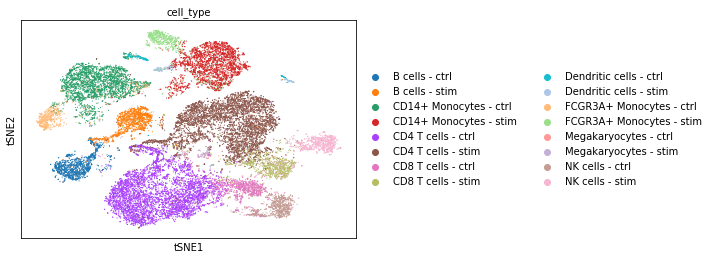

In [17]:
sc.pl.tsne(adata, color='cell_type')

In [18]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [20]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Cell type specific co-expression

for CD4 T cell:

gene_1, gene_2 = 'CXCR4', 'EEF1D'

gene_1, gene_2 = 'CXCR4', 'EEF1A1'

gene_1, gene_2 = 'PFDN5', 'OAZ1'

gene_1, gene_2 = 'UBB', 'OAZ1'

for CD14:

gene_1, gene_2 = 'EEF1D', 'BTG1'




In [21]:
def plot_microscopy(X, c1, c2, s=5, q_up=.95, q_down=0.1, min_val=0.1, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1 = np.clip(c1, a_min=np.quantile(c1, q_down), a_max=np.quantile(c1, q_up))
    c2 = np.clip(c2, a_min=np.quantile(c2, q_down), a_max=np.quantile(c2, q_up))

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    
    c1 = np.clip(c1, a_min=min_val, a_max=1)
    c2 = np.clip(c2, a_min=min_val, a_max=1)
    
    plt.subplot(1, 3, 1); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, np.zeros(N), np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 2); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([np.zeros(N), c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 3); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    df = pd.DataFrame(df_list, columns=['ct', 'stim','ind', 'corr']).sort_values('ct')
    df['corr'] = df['corr'].apply(lambda x: np.nan if abs(x) > 1 else x)
    
    return df
    

In [ ]:
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(estimator)

adata_dict = {}
for ct in cts:
    print('Processing', ct)
    adata_ct =  adata[adata.obs.stim == 'ctrl'].copy()
#     adata_ct.obs['cell'] = np.random.choice(adata_ct.obs['cell'], adata_ct.shape[0], replace=False)
    adata_ct.obs['ct'] = adata_ct.obs['cell'].apply( lambda x: int(x == ct))# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
    scmemo.create_groups(adata_ct, label_columns=['ct', 'cell' ,'ind'], inplace=True)

    scmemo.compute_1d_moments(
        adata_ct, inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.25, 
        min_perc_group=0.99)
    print('Size of data', adata_ct.shape)

    available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
    target_genes = adata_ct.var.index.tolist()
    target_genes = [gene for gene in target_genes if gene[:2] != 'RP' and gene[:3] != 'HLA']
    # target_genes = np.random.choice(target_genes, 50)
    print('TF list length', len(available_tfs))
    print('target gene length', len(target_genes))
    scmemo.compute_2d_moments(adata_ct, target_genes, target_genes)
    
    scmemo.ht_2d_moments(adata_ct, formula_like='1 + ct', cov_column='ct', num_boot=5000, num_cpus=6)
    adata_ct.write(data_path + 'result_2d/ct_specific_{}_05292020.h5ad'.format(label_converter[ct]))
    
    adata_dict[ct] = adata_ct.copy()

Processing CD4 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD14+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing FCGR3A+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing NK cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD8 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min


In [ ]:
df = scmemo.get_2d_ht_result(adata_dict['CD4 T cells'])
df.query('corr_fdr < 0.2').sort_values('corr_coef')#.head(20)

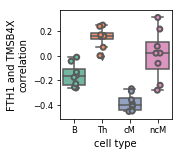

In [26]:
# EEF1A1	EEF1D

plt.figure(figsize=(2, 2))
gene_1, gene_2 = 'FTH1', 'TMSB4X'
plot_df = get_ct_ind_corr(adata_ct, gene_1, gene_2).query('ct in ["B","Th","cM","ncM"]')
sns.boxplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2', linewidth=2)
plt.ylabel('FTH1 and TMSB4X\ncorrelation')
plt.xlabel('cell type')
# plt.title('Correlation\nbetween\nFTH1 and TMSB4X')
plt.savefig(fig_path + 'fth1_tmsb4x.pdf', bbox_inches='tight')

In [628]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

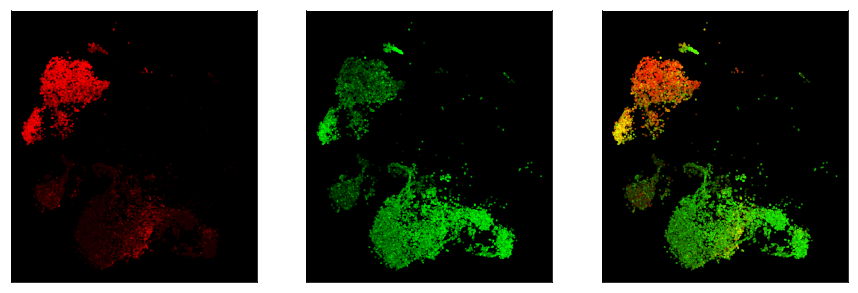

In [656]:
plt.figure(figsize=(15, 5))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl')]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.0,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True)

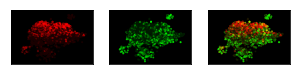

In [650]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-40, -5),ylim=(2, 37))
plt.savefig(fig_path + 'fth1_tmsb4x_cd14.pdf', bbox_inches='tight')

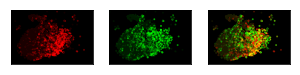

In [651]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD4 T cells'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-25, 25),ylim=(-40, 0))
plt.savefig(fig_path + 'fth1_tmsb4x_cd4.pdf', bbox_inches='tight')